# Demo - White Box Attack (Imagenet)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD

from models import Holdout, Target
from utils import imshow
import time

In [2]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.7.1
Torchvision 0.8.2
Torchattacks 3.2.4
Numpy 1.20.2


## 1. Load Data

In [3]:
batch_size = 8

cifar10_train = dsets.CIFAR10(root='./data', train=True,
                              download=True, transform=transforms.ToTensor())
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                              download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(cifar10_train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


True Image & True Label


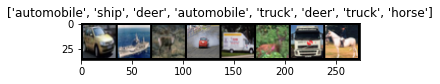

In [4]:
images, labels = iter(train_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [cifar10_train.classes[i] for i in labels])

## 2. Load Inception v3

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [6]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
# Adding a normalization layer for Resnet18.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    Target()
).to(device)

model = model.eval()

## 3. Adversarial Attack

In [8]:
from torchattacks import *

In [9]:
atks = [
    FGSM(model, eps=8/255),
    BIM(model, eps=8/255, alpha=2/255, steps=100),
    RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    GN(model),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

In [16]:
print("Adversarial Image & Predicted Label")

for atk in atks :
    
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        start = time.time()
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = model(adv_images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        # imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [cifar10_train.classes[i] for i in pre])
        # break
    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    break

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)
Total elapsed time (sec): 0.01
Robust accuracy: 4.46 %


In [15]:
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Robust accuracy: 60.94 %


In [15]:
labels

tensor([1, 0, 1, 1, 6, 6, 3, 3, 7, 7, 3, 0, 3, 3, 6, 1, 4, 6, 8, 0, 4, 7, 5, 2],
       device='cuda:0')